<a href="https://colab.research.google.com/github/pumpzcc/EvolutionaryDeepLearning/blob/main/EDL_12_2_GEPPY_Gym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
!pip install geppy
!pip install gym
!pip install mediapy -q

In [65]:
!apt-get install -y xvfb x11-utils
# install required python dependencies
!pip install gym[box2d]==0.17.* \
            pyvirtualdisplay==0.2.* \
            PyOpenGL==3.1.* \
            PyOpenGL-accelerate==3.1.* \
            mediapy \
            piglet -q
!pip install pyvirtualdisplay==0.2.* -q

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
x11-utils is already the newest version (7.7+5build2).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.15).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (box2d-py)


In [66]:
!echo $DISPLAY

:1013


In [67]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1017'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1017'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [68]:
import geppy as gep
from deap import creator, base, tools
import numpy as np
import random

import gym.wrappers
import os
import mediapy
import matplotlib.pyplot as plt
from IPython.display import clear_output

import gym

if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
# for reproduction
s = 0
random.seed(s)
np.random.seed(s)

action space: Box(-1.0, 1.0, (1,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


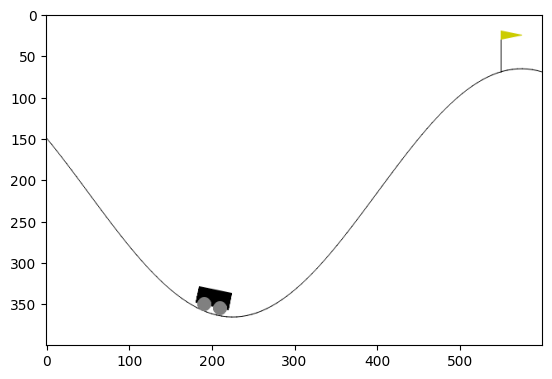

In [69]:
#@title Siumlate Environment Run { run: "auto" }
ENVIRONMENT = "MountainCarContinuous-v0" #@param ['Pendulum-v0', 'MountainCarContinuous-v0']

env = gym.make(ENVIRONMENT)

env.reset()
plt.imshow(env.render(mode='rgb_array'))

print("action space: {0!r}".format(env.action_space))
print("observation space: {0!r}".format(env.observation_space))

In [70]:
def protected_div(x1, x2):
    if abs(x2) < 1e-6:
        return 1
    return x1 / x2

In [71]:
import operator

if ENVIRONMENT == "Pendulum-v0":
  pset = gep.PrimitiveSet('Main', input_names=['x', 'y', 'velocity'])
elif ENVIRONMENT == "MountainCarContinuous-v0":
  pset = gep.PrimitiveSet('Main', input_names=['x', 'y'])
pset.add_function(operator.add, 2)
pset.add_function(operator.sub, 2)
pset.add_function(operator.mul, 2)
pset.add_function(protected_div, 2)
pset.add_ephemeral_terminal(name='enc', gen=lambda: random.randint(-10, 10)) # each ENC is a random integer within [-10, 10]

In [72]:
from deap import creator, base, tools

creator.create("FitnessMax", base.Fitness, weights=(1,))  # to minimize the objective (fitness)
creator.create("Individual", gep.Chromosome, fitness=creator.FitnessMax)

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [73]:
h = 7 # head length
n_genes = 2   # number of genes in a chromosome

In [74]:
toolbox = gep.Toolbox()
toolbox.register('gene_gen', gep.Gene, pset=pset, head_length=h)
toolbox.register('individual', creator.Individual, gene_gen=toolbox.gene_gen, n_genes=n_genes, linker=operator.add)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# compile utility: which translates an individual into an executable function (Lambda)
toolbox.register('compile', gep.compile_, pset=pset)

In [75]:
#@title Simulation Options { run: "auto" }
SIMULATION_STEPS = 99
SIMULATION_RUNS = 10 #@param {type:"slider", min:1, max:10, step:1}

In [76]:
print(env.action_space.low)

[-1.]


In [77]:
def func_random(state):
  return env.action_space.sample()

frames = []
fitness = 0
for run in range(SIMULATION_RUNS):
  state = env.reset()
  for i in range(SIMULATION_STEPS):
    action = func_random(state)
    state, reward, done, info = env.step(action)
    fitness += reward # reward for each step
    frames.append(env.render(mode='rgb_array'))
    if done:
      break

print(fitness)
mediapy.show_video(frames, fps=30)

-32.66814789725399


In [78]:
if ENVIRONMENT == "Pendulum-v0":
  def func(x, y, velocity):
    return x * y / velocity
elif ENVIRONMENT == "MountainCarContinuous-v0":
  def func(x, y):
    return x * y

def func_random(state):
  env.action_space.sample()

def clamp(minv, maxv, val):
  return min(max(minv, val), maxv)

def convert_to_action(act, env):
  #convert act space to within environment action space
  return clamp(env.action_space.low, env.action_space.high, act)

frames = []
fitness = 0

state = env.reset()
for i in range(SIMULATION_STEPS):
  action = convert_to_action(func(*state), env)
  state, reward, done, info = env.step([action])
  fitness += reward # reward for each step
  frames.append(env.render(mode='rgb_array'))
  if done:
    break

print(fitness)
mediapy.show_video(frames, fps=30)

-2.0815638663962464e-05


In [79]:
def evaluate(individual):
    """Evalute the fitness of an individual"""
    func = toolbox.compile(individual)
    fitness = 0
    for run in range(SIMULATION_RUNS):
      state = env.reset()
      actions=[]
      for i in range(SIMULATION_STEPS):
        action = convert_to_action(func(*state), env)
        state, reward, done, info = env.step(np.array([action]))
        fitness += reward
        if done:
          break

    return fitness,

In [85]:
toolbox.register('select', tools.selTournament, tournsize=3)
# 1. general operators
toolbox.register("evaluate", evaluate)
toolbox.register('mut_uniform', gep.mutate_uniform, pset=pset, ind_pb=0.05, pb=1)
toolbox.register('mut_invert', gep.invert, pb=0.1)
toolbox.register('mut_is_transpose', gep.is_transpose, pb=0.1)
toolbox.register('mut_ris_transpose', gep.ris_transpose, pb=0.1)
toolbox.register('mut_gene_transpose', gep.gene_transpose, pb=0.1)
toolbox.register('cx_1p', gep.crossover_one_point, pb=0.4)
toolbox.register('cx_2p', gep.crossover_two_point, pb=0.2)
toolbox.register('cx_gene', gep.crossover_gene, pb=0.1)
toolbox.register('mut_ephemeral', gep.mutate_uniform_ephemeral, ind_pb='1p')  # 1p: expected one point mutation in an individual
toolbox.pbs['mut_ephemeral'] = 1  # we can also give the probability via the pbs property

In [81]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [82]:
def show_best(best):
  func = toolbox.compile(best)
  frames = []
  fitness = 0
  state = env.reset()
  for i in range(SIMULATION_STEPS):
    action = convert_to_action(func(*state), env)
    state, reward, done, info = env.step(np.array([action]))
    frames.append(env.render(mode='rgb_array'))
    fitness += reward
    if done:
      break

  mediapy.show_video(frames, fps=30)
  try:
    symplified_best = gep.simplify(best)
    print(f'Symplified best individual: {fitness}')
    print(symplified_best)
  except:
    pass

In [ ]:
#@title Evolve the Equation
# size of population and number of generations
POPULATION = 1000 #@param {type:"slider", min:10, max:1000, step:5}
GENERATIONS = 250 #@param {type:"slider", min:10, max:250, step:1}

pop = toolbox.population(n=POPULATION)
hof = tools.HallOfFame(3)   # only record the best three individuals ever found in all generations

# start evolution
for gen in range(GENERATIONS):
  pop, log = gep.gep_simple(pop, toolbox, n_generations=1, n_elites=1,
                            stats=stats, hall_of_fame=hof, verbose=True)
  clear_output()
  print(f"GENERATION: {gen}")
  best = hof[0]
  show_best(best)

GENERATION: 0


/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Symplified best individual: 92.17591273008725
x*(x + y)/y
gen	nevals	avg     	std    	min	max    
0  	0     	-26.7419	162.493	-99	925.285


In [ ]:
# we want use symbol labels instead of words in the tree graph
best = hof[0]
rename_labels = {'add': '+', 'sub': '-', 'mul': '*', 'protected_div': '/'}
gep.export_expression_tree(best, rename_labels, 'data/numerical_expression_tree.png')

# show the above image here for convenience
from IPython.display import Image
Image(filename='data/numerical_expression_tree.png')